<a href="https://colab.research.google.com/github/fawazshah/Reddit-Analysis/blob/main/5_direct_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
!pip install transformers

     |████████████████████████████████| 2.3MB 9.0MB/s 
     |████████████████████████████████| 901kB 55.1MB/s 
     |████████████████████████████████| 3.3MB 65.2MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import requests
from sklearn.metrics import f1_score, accuracy_score, classification_report
import time
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers

In [3]:
# Setting random seed and device
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

### BERT setup

In [4]:
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
def compute_sentences_article_body(df):
    return list(df['article body'])

def compute_sentences_comment_body(df):
    return list(df['comment body'])

In [7]:
def create_bert_dataset(df, bert_input_func, max_sequence_len):
    # Returns a TensorDataset of sequences extracted from df

    token_ids = []
    token_type_ids = [] # segment ids 
    attention_masks = []

    sentences = bert_input_func(df)

    for sent in sentences:
        encoding_dict = tokenizer(sent,
                                  add_special_tokens=True,
                                  max_length=max_sequence_len,
                                  padding='max_length',
                                  truncation=True,
                                  return_token_type_ids = True,
                                  return_attention_mask = True,
                                  return_tensors = 'pt'
                                  )
        token_ids.append(encoding_dict['input_ids'])
        token_type_ids.append(encoding_dict['token_type_ids'])
        attention_masks.append(encoding_dict['attention_mask'])
    
    token_ids = torch.cat(token_ids, dim=0)
    token_type_ids = torch.cat(token_type_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(df['bias'].values)
    
    return TensorDataset(token_ids, token_type_ids, attention_masks, labels)

In [8]:
def train_BERT(train_dataloader, val_dataloader, model, number_epoch):

    train_loss = []
    valid_loss = []

    optimizer = AdamW(model.parameters(),
                    lr = 2e-5, 
                    eps = 1e-8 
                )

    # Create the learning rate scheduler.
    total_steps = len(train_dataloader) * number_epoch
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
                                                num_training_steps=total_steps)

    for epoch in range(1, number_epoch+1):

        # TRAINING

        time0 = time.time()

        model.train()

        epoch_train_loss = 0
        no_observations = 0
        epoch_train_predictions = []
        epoch_train_labels = []

        for batch in train_dataloader:

            # Each batch contains token ids, token type ids, attention masks and labels
            b_token_ids = batch[0].to(device)
            b_token_type_ids = batch[1].to(device)
            b_attention_masks = batch[2].to(device)
            b_labels = batch[3].to(device)

            no_observations = no_observations + b_labels.shape[0]
            
            output = model(b_token_ids, 
                    token_type_ids=b_token_type_ids, 
                    attention_mask=b_attention_masks, 
                    labels=b_labels)

            model.zero_grad()

            loss = output.loss
            logits = output.logits

            predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
            labels = b_labels.detach().cpu().numpy()
            epoch_train_predictions.extend(predictions)
            epoch_train_labels.extend(labels)

            loss.backward()
            # Clip the norm of the gradients to 1 to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step() 

            # Update the learning rate using the scheduler
            scheduler.step()  

            epoch_train_loss += loss.item()*b_labels.shape[0]

        epoch_train_loss, epoch_train_acc = epoch_train_loss / no_observations, accuracy_score(epoch_train_labels, epoch_train_predictions)

        # VALIDATION

        epoch_valid_loss, epoch_val_predictions, epoch_val_labels = evaluate_BERT(val_dataloader, model)
        epoch_valid_acc = accuracy_score(epoch_val_labels, epoch_val_predictions)

        # FINALLY

        print(f"Epoch took: {time.time() - time0}")

        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_train_loss:.2f} | Train Accuracy: {epoch_train_acc:.2f} | \
        Val. Loss: {epoch_valid_loss:.2f} | Val. Accuracy: {epoch_valid_acc:.2f} |')

        train_loss.append(epoch_train_loss)
        valid_loss.append(epoch_valid_loss)
    
    return train_loss, valid_loss

In [9]:
def evaluate_BERT(test_dataloader, model):

    model.eval()
    total_loss = 0
    no_observations = 0
    predictions_all = []
    labels_all = []

    with torch.no_grad():
        for batch in test_dataloader:
            b_token_ids = batch[0].to(device)
            b_token_type_ids = batch[1].to(device)
            b_attention_masks = batch[2].to(device)
            b_labels = batch[3].to(device)

            no_observations += b_labels.shape[0]
            output = model(b_token_ids, token_type_ids=b_token_type_ids, 
                                        attention_mask=b_attention_masks)
            logits = output.logits
            loss = loss_fn(logits, b_labels)

            predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
            labels = b_labels.detach().cpu().numpy()
            predictions_all.extend(predictions)
            labels_all.extend(labels)

            total_loss += loss.item()*b_labels.shape[0]
    
    return total_loss / no_observations, predictions_all, labels_all

### Article body -> comments

#### Loading data

In [10]:
submissions_url = 'https://raw.githubusercontent.com/fawazshah/Reddit-Analysis/master/data/collated-data/submissions_preprocessed_shuffled.tsv'
submissions_df = pd.read_csv(submissions_url, sep='\t')

comments_url = 'https://raw.githubusercontent.com/fawazshah/Reddit-Analysis/master/data/collated-data/comments_preprocessed_shuffled.tsv'
comments_df = pd.read_csv(comments_url, sep='\t')

In [11]:
print(f"No. submissions: {len(submissions_df)}")
print(f"No. comments: {len(comments_df)}")

No. submissions: 807
No. comments: 11934


#### Split data into train/val/test

In [12]:
# Train/val/test split

TRAIN = 0.7
VAL = 0.1
TEST = 0.2

In [13]:
split_point_1 = int(TRAIN*len(submissions_df))
split_point_2 = int((TRAIN+VAL)*len(submissions_df))

submissions_train_df = submissions_df.iloc[:split_point_1].copy()
submissions_val_df = submissions_df.iloc[split_point_1:split_point_2].copy()
submissions_test_df = submissions_df.iloc[split_point_2:].copy()

In [14]:
print(f"Size of training set: {len(submissions_train_df)}")
print(f"Size of validation set: {len(submissions_val_df)}")
print(f"Size of test set: {len(submissions_test_df)}")

Size of training set: 564
Size of validation set: 81
Size of test set: 162


#### Create BERT dataloaders

In [15]:
dataloaders = {}
BATCH_SIZE = 10

In [16]:
# Using no folds
dataloaders['article bodies'] = {}
train_dataset = create_bert_dataset(submissions_train_df, compute_sentences_article_body, 512)
dataloaders['article bodies']['train'] = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
val_dataset = create_bert_dataset(submissions_val_df, compute_sentences_article_body, 512)
dataloaders['article bodies']['val'] = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataset = create_bert_dataset(submissions_test_df, compute_sentences_article_body, 512)
dataloaders['article bodies']['test'] = DataLoader(test_dataset, sampler=RandomSampler(test_dataset), batch_size=BATCH_SIZE)

In [17]:
comment_dataset = create_bert_dataset(comments_df, compute_sentences_comment_body, 512)
dataloaders['comment bodies'] = DataLoader(comment_dataset, sampler = RandomSampler(comment_dataset), batch_size=BATCH_SIZE)

#### Run BERT models

In [18]:
NUM_EPOCHS = 5

In [19]:
# Train and test on article bodies

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

# Train model on article bodies
train_dataloader = dataloaders['article bodies']['train']
val_dataloader = dataloaders['article bodies']['val']
train_loss, valid_loss = train_BERT(train_dataloader, val_dataloader, model, NUM_EPOCHS)

# Test on article bodies
_, predictions, labels = evaluate_BERT(dataloaders['article bodies']['test'], model)

print(classification_report(labels, predictions))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch took: 18.65322995185852
| Epoch: 01 | Train Loss: 0.69 | Train Accuracy: 0.55 |         Val. Loss: 0.62 | Val. Accuracy: 0.72 |
Epoch took: 18.55969262123108
| Epoch: 02 | Train Loss: 0.59 | Train Accuracy: 0.73 |         Val. Loss: 0.59 | Val. Accuracy: 0.65 |
Epoch took: 18.582258462905884
| Epoch: 03 | Train Loss: 0.55 | Train Accuracy: 0.73 |         Val. Loss: 0.50 | Val. Accuracy: 0.75 |
Epoch took: 18.603288650512695
| Epoch: 04 | Train Loss: 0.46 | Train Accuracy: 0.78 |         Val. Loss: 0.52 | Val. Accuracy: 0.72 |
Epoch took: 18.606011867523193
| Epoch: 05 | Train Loss: 0.42 | Train Accuracy: 0.81 |         Val. Loss: 0.54 | Val. Accuracy: 0.73 |
              precision    recall  f1-score   support

           0       0.73      0.81      0.77        79
           1       0.80      0.71      0.75        83

    accuracy                           0.76       162
   macro avg       0.76      0.76      0.76       162
weighted avg       0.76      0.76      0.76       162



In [20]:
# Infer on comments

_, predictions, labels = evaluate_BERT(dataloaders['comment bodies'], model)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.58      0.29      0.39      5969
           1       0.53      0.80      0.63      5965

    accuracy                           0.54     11934
   macro avg       0.56      0.54      0.51     11934
weighted avg       0.56      0.54      0.51     11934



### Comments -> article body

#### Loading data

In [18]:
submissions_url = 'https://raw.githubusercontent.com/fawazshah/Reddit-Analysis/master/data/collated-data/submissions_preprocessed_shuffled.tsv'
submissions_df = pd.read_csv(submissions_url, sep='\t')

comments_url = 'https://raw.githubusercontent.com/fawazshah/Reddit-Analysis/master/data/collated-data/comments_preprocessed_shuffled.tsv'
comments_df = pd.read_csv(comments_url, sep='\t')

In [19]:
print(f"No. submissions: {len(submissions_df)}")
print(f"No. comments: {len(comments_df)}")

No. submissions: 807
No. comments: 11934


#### Split data into train/val/test

In [20]:
# Train/val/test split

TRAIN = 0.7
VAL = 0.1
TEST = 0.2

In [21]:
split_point_1 = int(TRAIN*len(comments_df))
split_point_2 = int((TRAIN+VAL)*len(comments_df))

comments_train_df = comments_df.iloc[:split_point_1].copy()
comments_val_df = comments_df.iloc[split_point_1:split_point_2].copy()
comments_test_df = comments_df.iloc[split_point_2:].copy()

In [22]:
print(f"Size of training set: {len(comments_train_df)}")
print(f"Size of validation set: {len(comments_val_df)}")
print(f"Size of test set: {len(comments_test_df)}")

Size of training set: 8353
Size of validation set: 1194
Size of test set: 2387


#### Create BERT dataloaders

In [23]:
dataloaders = {}
BATCH_SIZE = 10

In [24]:
# Using no folds
dataloaders['comment bodies'] = {}
train_dataset = create_bert_dataset(comments_train_df, compute_sentences_comment_body, 512)
dataloaders['comment bodies']['train'] = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
val_dataset = create_bert_dataset(comments_val_df, compute_sentences_comment_body, 512)
dataloaders['comment bodies']['val'] = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataset = create_bert_dataset(comments_test_df, compute_sentences_comment_body, 512)
dataloaders['comment bodies']['test'] = DataLoader(test_dataset, sampler=RandomSampler(test_dataset), batch_size=BATCH_SIZE)

In [25]:
article_dataset = create_bert_dataset(submissions_df, compute_sentences_article_body, 512)
dataloaders['article bodies'] = DataLoader(article_dataset, sampler = RandomSampler(article_dataset), batch_size=BATCH_SIZE)

#### Run BERT models

In [29]:
NUM_EPOCHS = 5

In [30]:
# Train and test on comment bodies

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

# Train model on comment bodies
train_dataloader = dataloaders['comment bodies']['train']
val_dataloader = dataloaders['comment bodies']['val']
train_loss, valid_loss = train_BERT(train_dataloader, val_dataloader, model, NUM_EPOCHS)

# Test on comment bodies
_, predictions, labels = evaluate_BERT(dataloaders['comment bodies']['test'], model)

print(classification_report(labels, predictions))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch took: 273.361202955246
| Epoch: 01 | Train Loss: 0.66 | Train Accuracy: 0.60 |         Val. Loss: 0.61 | Val. Accuracy: 0.64 |
Epoch took: 273.4879095554352
| Epoch: 02 | Train Loss: 0.51 | Train Accuracy: 0.75 |         Val. Loss: 0.67 | Val. Accuracy: 0.64 |
Epoch took: 273.75930523872375
| Epoch: 03 | Train Loss: 0.32 | Train Accuracy: 0.87 |         Val. Loss: 0.98 | Val. Accuracy: 0.64 |
Epoch took: 273.8892276287079
| Epoch: 04 | Train Loss: 0.19 | Train Accuracy: 0.93 |         Val. Loss: 1.51 | Val. Accuracy: 0.65 |
Epoch took: 273.69087743759155
| Epoch: 05 | Train Loss: 0.12 | Train Accuracy: 0.96 |         Val. Loss: 1.83 | Val. Accuracy: 0.64 |
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1179
           1       0.67      0.67      0.67      1208

    accuracy                           0.67      2387
   macro avg       0.67      0.67      0.67      2387
weighted avg       0.67      0.67      0.67      2387



In [31]:
# Infer on articles

_, predictions, labels = evaluate_BERT(dataloaders['article bodies'], model)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       419
           1       0.67      0.71      0.69       388

    accuracy                           0.69       807
   macro avg       0.69      0.69      0.69       807
weighted avg       0.69      0.69      0.69       807



### Num. comments per post

In [32]:
comment_dist = pd.DataFrame(comments_df['submission id'].value_counts())
comment_dist['submission no.'] = range(1, 1+len(comment_dist))
comment_dist.rename(columns={'submission id': 'no. comments'}, inplace=True)
comment_dist.reset_index(drop=True, inplace=True)

In [33]:
comment_dist

,no. comments,submission no.
0,183,1
1,144,2
2,99,3
3,92,4
4,92,5
...,...,...
801,1,802
802,1,803
803,1,804
804,1,805


In [34]:
comment_dist['no. comments'].describe()

count    806.000000
mean      14.806452
std       17.547728
min        1.000000
25%        5.000000
50%       10.000000
75%       17.000000
max      183.000000
Name: no. comments, dtype: float64

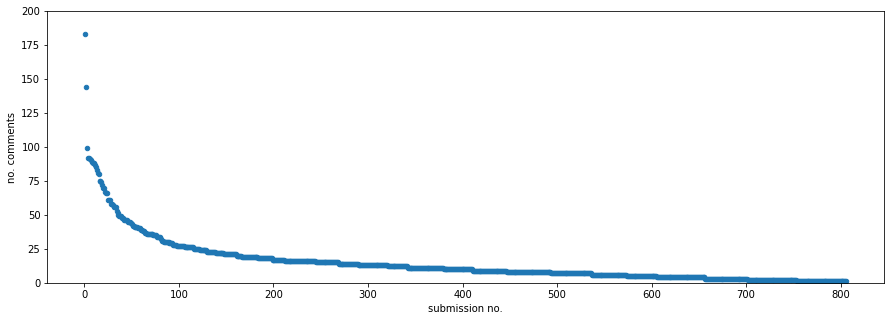

In [35]:
comment_dist.plot(x='submission no.', y='no. comments', kind='scatter', ylim=[0, 200], figsize=(15, 5))

### Comments -> article body with num. comments = num. articles

In [27]:
# Redo comments processing with reduced number of comments

comments_url = 'https://raw.githubusercontent.com/fawazshah/Reddit-Analysis/master/data/collated-data/comments_preprocessed_shuffled.tsv'
comments_df = pd.read_csv(comments_url, sep='\t')

comments_df = comments_df.sample(frac=0.5)
comments_df.reset_index(inplace=True, drop=True)

#### Split data into train/val/test

In [29]:
# Train/val/test split

TRAIN = 0.7
VAL = 0.1
TEST = 0.2

In [30]:
split_point_1 = int(TRAIN*len(comments_df))
split_point_2 = int((TRAIN+VAL)*len(comments_df))

comments_train_df = comments_df.iloc[:split_point_1].copy()
comments_val_df = comments_df.iloc[split_point_1:split_point_2].copy()
comments_test_df = comments_df.iloc[split_point_2:].copy()

In [31]:
print(f"Size of training set: {len(comments_train_df)}")
print(f"Size of validation set: {len(comments_val_df)}")
print(f"Size of test set: {len(comments_test_df)}")

Size of training set: 4176
Size of validation set: 597
Size of test set: 1194


#### Create BERT dataloaders

In [32]:
dataloaders = {}
BATCH_SIZE = 10

In [33]:
# Using no folds
dataloaders['comment bodies'] = {}
train_dataset = create_bert_dataset(comments_train_df, compute_sentences_comment_body, 512)
dataloaders['comment bodies']['train'] = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
val_dataset = create_bert_dataset(comments_val_df, compute_sentences_comment_body, 512)
dataloaders['comment bodies']['val'] = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataset = create_bert_dataset(comments_test_df, compute_sentences_comment_body, 512)
dataloaders['comment bodies']['test'] = DataLoader(test_dataset, sampler=RandomSampler(test_dataset), batch_size=BATCH_SIZE)

In [34]:
article_dataset = create_bert_dataset(submissions_df, compute_sentences_article_body, 512)
dataloaders['article bodies'] = DataLoader(article_dataset, sampler = RandomSampler(article_dataset), batch_size=BATCH_SIZE)

#### Run BERT models

In [35]:
NUM_EPOCHS = 5

In [36]:
# Train and test on comment bodies

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

# Train model on comment bodies
train_dataloader = dataloaders['comment bodies']['train']
val_dataloader = dataloaders['comment bodies']['val']
train_loss, valid_loss = train_BERT(train_dataloader, val_dataloader, model, NUM_EPOCHS)

# Test on comment bodies
_, predictions, labels = evaluate_BERT(dataloaders['comment bodies']['test'], model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch took: 249.04448461532593
| Epoch: 01 | Train Loss: 0.69 | Train Accuracy: 0.55 |         Val. Loss: 0.66 | Val. Accuracy: 0.63 |
Epoch took: 248.78671193122864
| Epoch: 02 | Train Loss: 0.59 | Train Accuracy: 0.68 |         Val. Loss: 0.65 | Val. Accuracy: 0.64 |
Epoch took: 248.80056858062744
| Epoch: 03 | Train Loss: 0.40 | Train Accuracy: 0.83 |         Val. Loss: 0.72 | Val. Accuracy: 0.65 |
Epoch took: 248.91853046417236
| Epoch: 04 | Train Loss: 0.26 | Train Accuracy: 0.90 |         Val. Loss: 1.20 | Val. Accuracy: 0.67 |
Epoch took: 248.75397777557373
| Epoch: 05 | Train Loss: 0.16 | Train Accuracy: 0.95 |         Val. Loss: 1.50 | Val. Accuracy: 0.65 |


In [37]:
# Infer on articles

_, predictions, labels = evaluate_BERT(dataloaders['article bodies'], model)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69       419
           1       0.67      0.49      0.57       388

    accuracy                           0.64       807
   macro avg       0.65      0.64      0.63       807
weighted avg       0.65      0.64      0.63       807

